In [4]:
# ITC6125A1 - MACHINE LEARNING & APPLICATIONS - SPRING TERM 2022
# Term Project - Traffic Sign Classifier
# Students:
#     Ioannis Fitsopoulos - s-if257217
#     Trafalis Panagiotis - s-pt256311
# Instructor: Milioris Dimitrios

## Imports

In [5]:
import gc
import itertools
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sn
import tensorflow as tf
import time
%matplotlib inline
import cv2

from PIL import Image

from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D # Layers to be used for building our model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
import zipfile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import tensorflow as tf
import keras
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout
from sklearn.model_selection import train_test_split

log = logging.getLogger('tensorflow')
log.setLevel(logging.ERROR)

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.0


In [6]:
df = pd.read_csv("C:\\Users\\johnfitsos\\Desktop\\mlapps\\Traffic_Sign_Dataset\\Train.csv")
df

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png
...,...,...,...,...,...,...,...,...
39204,52,56,5,6,47,51,42,Train/42/00042_00007_00025.png
39205,56,58,5,5,51,53,42,Train/42/00042_00007_00026.png
39206,58,62,5,6,53,57,42,Train/42/00042_00007_00027.png
39207,63,69,5,7,58,63,42,Train/42/00042_00007_00028.png


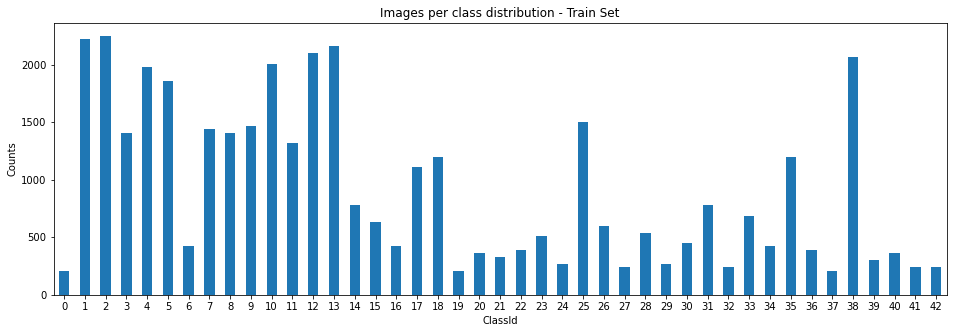

In [78]:
plt.figure(figsize=(16,5))
df.groupby(by="ClassId").count()["Path"].plot.bar()
plt.title("Images per class distribution - Train Set")
plt.xticks(rotation=0)
plt.ylabel("Counts")
plt.savefig('Train_class_distribution.jpeg')
plt.show()

In [8]:
df.shape

(39209, 8)

In [9]:
df.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000


In [10]:
df2 = pd.read_csv("C:\\Users\\johnfitsos\\Desktop\\mlapps\\Traffic_Sign_Dataset\\Test.csv")
df2

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
...,...,...,...,...,...,...,...,...
12625,42,41,5,6,37,36,12,Test/12625.png
12626,50,51,6,5,45,46,33,Test/12626.png
12627,29,29,6,6,24,24,6,Test/12627.png
12628,48,49,5,6,43,44,7,Test/12628.png


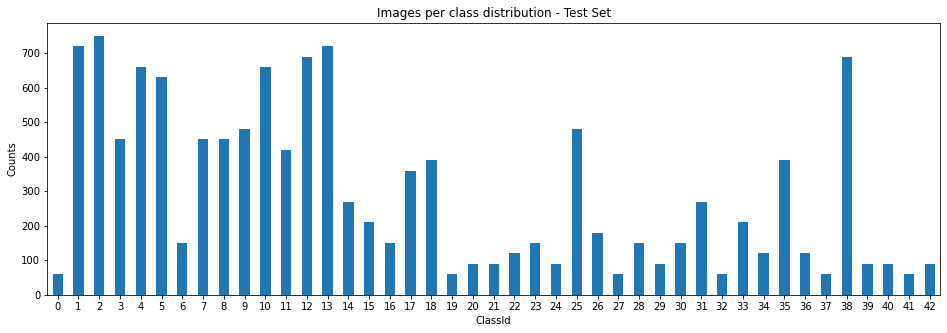

In [77]:
plt.figure(figsize=(16,5))
df2.groupby(by="ClassId").count()["Path"].plot.bar()
plt.title("Images per class distribution - Test Set")
plt.xticks(rotation=0)
plt.ylabel("Counts")
plt.savefig('Test_class_distribution.jpeg')
plt.show()

In [12]:
df2.shape

(12630, 8)

In [13]:
df2.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000
mean,50.507759,50.364450,5.998021,5.982423,44.864450,44.758116,15.551069
std,25.088483,23.698908,1.543954,1.427424,23.776102,22.494697,11.947123
min,25.000000,25.000000,1.000000,5.000000,20.000000,20.000000,0.000000
25%,34.000000,35.000000,5.000000,5.000000,29.000000,29.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,57.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,266.000000,232.000000,23.000000,19.000000,244.000000,212.000000,42.000000


# Read Images
Loop over all the directories, load the images. preprocess them and add them to an array

Data: List with images - List of arrays with images

Labels: List with classes

The first item of the list labels corresponds to the first array of the list data

Preprocessing:

    1) Convert image to grayscale - 1 dimensional and lightweight
    2) Resize image in (100,100)
    3) Optional: Apply Gaussian Filter to enhance edges and remove noise (did nor applied in the example)
    4) Representation of image in an array
    5) Normalize pixel values - which helps in the training process

In [14]:
imgs_path = "\\Users\\johnfitsos\\Desktop\\mlapps\\Traffic_Sign_Dataset\\Train"
data = []
labels = []
classes = 43
for i in range(classes):
    img_path = os.path.join(imgs_path, str(i)) #0-42
    for img in os.listdir(img_path):
        # Loading and Preprocessing
        im = Image.open(img_path + '/' + img).convert('L')
        im = im.resize((100,100))
        im = np.array(im)
        im = im/255
        
        data.append(im)
        labels.append(i)
data = np.array(data)
labels = np.array(labels)

In [15]:
data.shape

(39209, 100, 100)

# Split data into training and validation set

Transform labels in categorical form

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
print("training shape: ",x_train.shape, y_train.shape)
print("testing shape: ",x_test.shape, y_test.shape)
y_test_labels = y_test
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

training shape:  (31367, 100, 100) (31367,)
testing shape:  (7842, 100, 100) (7842,)


In [17]:
x_train.shape
y_train.shape

(31367, 43)

# Build Model

The model outputs will be 43 classes with the corresponding probability of each class.

The output layer of the network uses softmax activation function.

Softmax converts a vector of numbers into a vector of probabilities, where the probabilities of each value are proportional to the relative scale of each value in the vector.

In [18]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu", input_shape = (100,100,1),padding="same")) #input_shape=x_train.shape[1:]))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu",padding="same"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten()) # Flatten the array for the dense layers
model.add(Dense(256, activation="relu"))
model.add(Dropout(rate=0.4))
model.add(Dense(128,activation="relu"))
model.add(Dense(43, activation="softmax"))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 40000)             0         
                                                                 
 dense (Dense)               (None, 256)               1

In [20]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit model

In [21]:
epochs = 5
history = model.fit(x_train, y_train, epochs=epochs, batch_size=64, validation_data=(x_test, y_test)) # batch_size =64

Epoch 1/5
491/491 [==============================] - 119s 241ms/step - loss: 1.4264 - accuracy: 0.6077 - val_loss: 0.2592 - val_accuracy: 0.9352
Epoch 2/5
491/491 [==============================] - 118s 241ms/step - loss: 0.3591 - accuracy: 0.8912 - val_loss: 0.1668 - val_accuracy: 0.9505
Epoch 3/5
491/491 [==============================] - 117s 239ms/step - loss: 0.2245 - accuracy: 0.9324 - val_loss: 0.0937 - val_accuracy: 0.9760
Epoch 4/5
491/491 [==============================] - 117s 238ms/step - loss: 0.1647 - accuracy: 0.9483 - val_loss: 0.0674 - val_accuracy: 0.9816
Epoch 5/5
491/491 [==============================] - 117s 238ms/step - loss: 0.1251 - accuracy: 0.9597 - val_loss: 0.0781 - val_accuracy: 0.9793


# Plot the losses

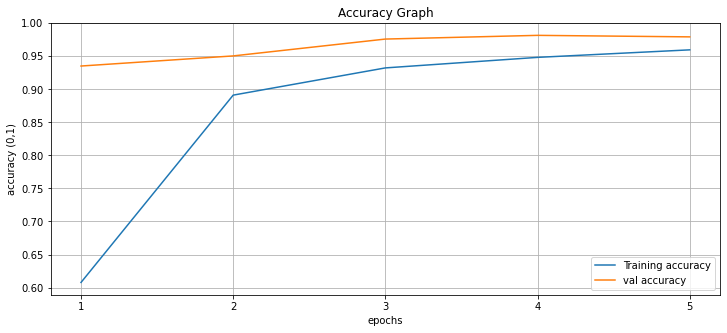

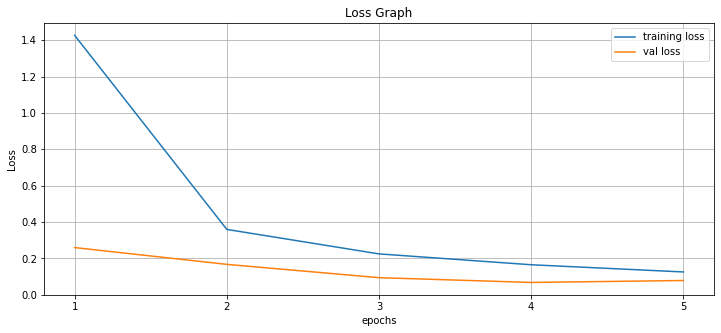

In [82]:
plt.figure(0,figsize=(12,5))
plt.plot([str(i) for i in range(1,epochs+1)] , history.history['accuracy'], label="Training accuracy")
plt.plot([str(i) for i in range(1,epochs+1)] ,history.history['val_accuracy'], label="val accuracy")
plt.title("Accuracy Graph")
plt.xlabel("epochs")
plt.ylabel("accuracy (0,1)")
plt.legend()
plt.grid()
plt.savefig('Model_Accuracy.jpeg')

plt.figure(1,figsize=(12,5))
plt.plot([str(i) for i in range(1,epochs+1)] , history.history['loss'], label="training loss")
plt.plot([str(i) for i in range(1,epochs+1)] , history.history['val_loss'], label="val loss")
plt.title("Loss Graph")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig('Model_Loss.jpeg')
plt.show()

# Load the test images and preprocess them on the same way with the train images

The dataset provides a second folder with unseen data that has not been used until now.

We use this dataset to simulate unseen data and test our model

In [23]:
from sklearn.metrics import accuracy_score
test = pd.read_csv("\\Users\\johnfitsos\\Desktop\\mlapps\\Traffic_Sign_Dataset\\Test.csv")
test_labels = test['ClassId'].values
test_img_path = "\\Users\\johnfitsos\\Desktop\\mlapps\\Traffic_Sign_Dataset"
test_imgs = test['Path'].values
#print(test_imgs)


test_data = []
test_labels = []

for img in test_imgs:
    # Loading and preprocessing
    im = Image.open(test_img_path + '/' + img).convert('L')
    im = im.resize((100,100))
    im = np.array(im)
    im = im/255
    test_data.append(im)

test_data = np.array(test_data)
print(test_data.shape)

import warnings
warnings.filterwarnings("ignore")
test_labels = test['ClassId'].values
test_labels



(12630, 100, 100)


array([16,  1, 38, ...,  6,  7, 10], dtype=int64)

In [24]:
print("training shape: ",test_data.shape, test_labels.shape)


training shape:  (12630, 100, 100) (12630,)


In [25]:
test_labels = to_categorical(test_labels, 43) # Transform labels to categorical form

In [26]:
model.evaluate(test_data,test_labels)

395/395 [==============================] - 11s 28ms/step - loss: 0.2857 - accuracy: 0.9279


[0.28568366169929504, 0.9278701543807983]

In [27]:
labels

array([ 0,  0,  0, ..., 42, 42, 42])

In [28]:
from sklearn.metrics import classification_report
y_true = y_test_labels
y_pred = model.predict(x_test)
y_pred= np.argmax(y_pred,axis=1)

target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9'
               , 'class 10', 'class 11', 'class 12', 'class 13', 'class 14', 'class 15', 'class 16', 'class 17', 'class 18', 'class 19',
                'class 20', 'class 21', 'class 22', 'class 23', 'class 24', 'class 25', 'class 26', 'class 27', 'class 28', 'class 29'
               , 'class 30', 'class 31', 'class 32', 'class 33', 'class 34', 'class 35', 'class 36', 'class 37', 'class 38', 'class 39'
               , 'class 40', 'class 41', 'class 42']
print(classification_report(y_true, y_pred, target_names=target_names))


              precision    recall  f1-score   support

     class 0       0.96      0.71      0.82        38
     class 1       0.98      0.97      0.98       496
     class 2       0.98      0.97      0.97       450
     class 3       0.95      0.97      0.96       280
     class 4       0.93      0.99      0.96       418
     class 5       0.98      0.91      0.95       364
     class 6       1.00      0.98      0.99        59
     class 7       0.99      0.95      0.97       278
     class 8       0.96      0.97      0.97       301
     class 9       0.99      0.97      0.98       268
    class 10       0.99      0.99      0.99       370
    class 11       1.00      0.98      0.99       236
    class 12       0.99      0.99      0.99       450
    class 13       0.98      1.00      0.99       452
    class 14       1.00      0.98      0.99       162
    class 15       0.93      1.00      0.96       120
    class 16       1.00      1.00      1.00        90
    class 17       0.98    

In [45]:
from sklearn.metrics import multilabel_confusion_matrix
y_true = y_test_labels
y_pred = model.predict(x_test)
y_pred= np.argmax(y_pred,axis=1)
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9'
               , 'class 10', 'class 11', 'class 12', 'class 13', 'class 14', 'class 15', 'class 16', 'class 17', 'class 18', 'class 19',
                'class 20', 'class 21', 'class 22', 'class 23', 'class 24', 'class 25', 'class 26', 'class 27', 'class 28', 'class 29'
               , 'class 30', 'class 31', 'class 32', 'class 33', 'class 34', 'class 35', 'class 36', 'class 37', 'class 38', 'class 39'
               , 'class 40', 'class 41', 'class 42']
mcm=multilabel_confusion_matrix(y_true, y_pred)
mcm

array([[[7803,    1],
        [  11,   27]],

       [[7338,    8],
        [  13,  483]],

       [[7381,   11],
        [  14,  436]],

       [[7547,   15],
        [   7,  273]],

       [[7395,   29],
        [   3,  415]],

       [[7471,    7],
        [  31,  333]],

       [[7783,    0],
        [   1,   58]],

       [[7562,    2],
        [  13,  265]],

       [[7529,   12],
        [   8,  293]],

       [[7572,    2],
        [   7,  261]],

       [[7469,    3],
        [   2,  368]],

       [[7605,    1],
        [   5,  231]],

       [[7388,    4],
        [   3,  447]],

       [[7381,    9],
        [   0,  452]],

       [[7680,    0],
        [   4,  158]],

       [[7713,    9],
        [   0,  120]],

       [[7752,    0],
        [   0,   90]],

       [[7619,    4],
        [   0,  219]],

       [[7609,    2],
        [   2,  229]],

       [[7793,    6],
        [   3,   40]],

       [[7761,    3],
        [   5,   73]],

       [[7778,    1],
        [   

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=10):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Class - " + class_label)

In [71]:
labels = ["".join("c" + str(i)) for i in range(0, 43)]

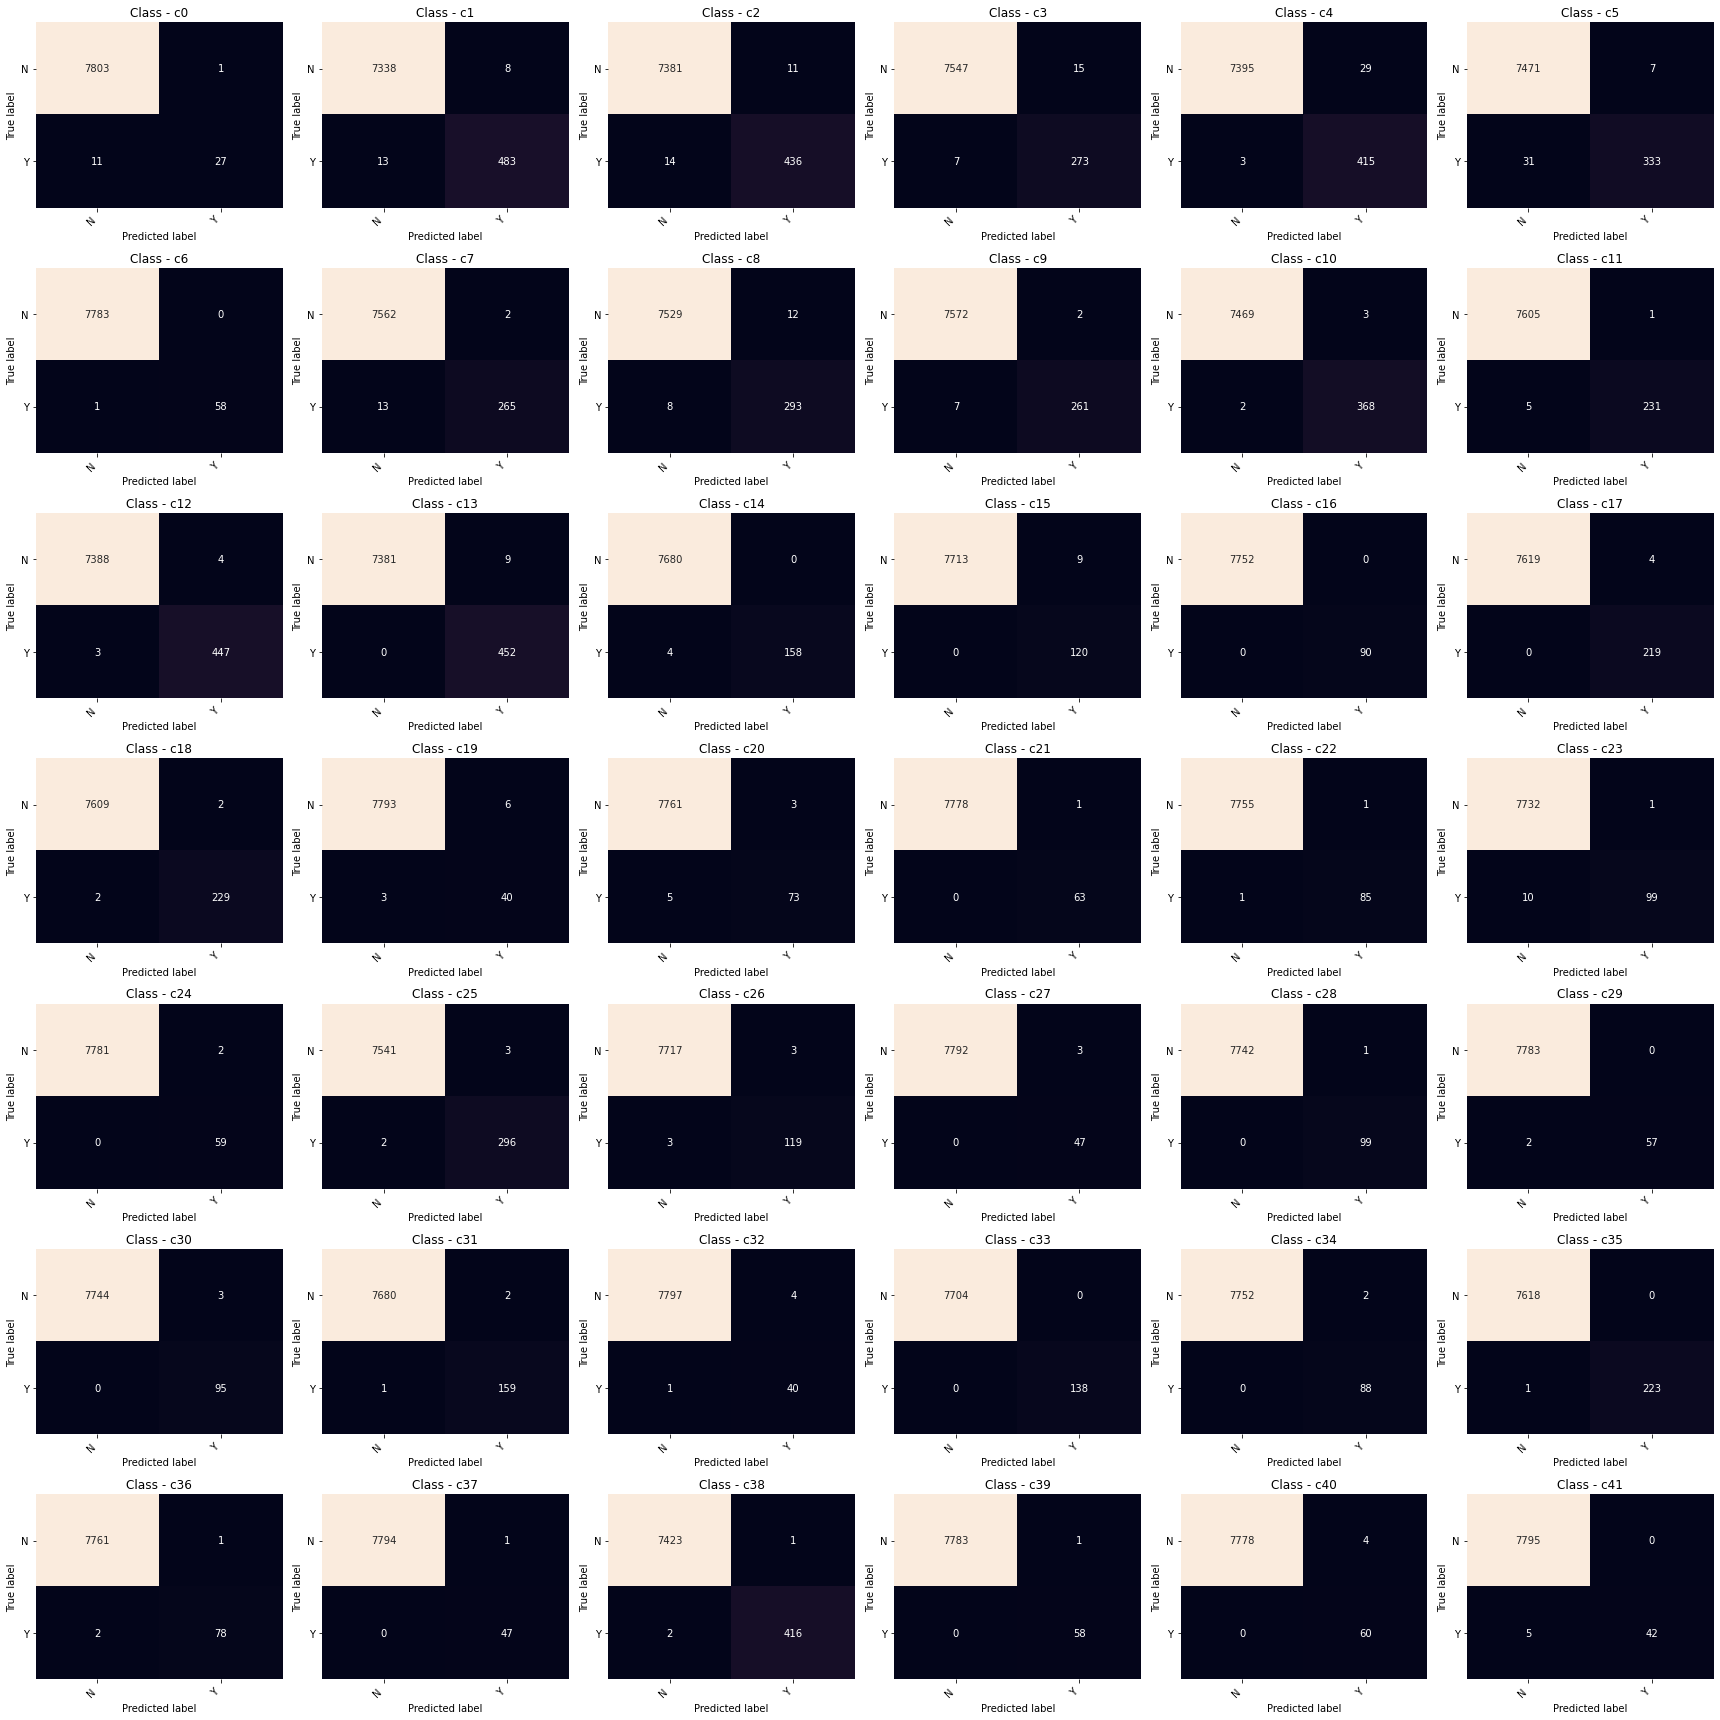

In [74]:
fig, ax = plt.subplots(7, 6, figsize=(24, 24))
    
for axes, cfs_matrix, label in zip(ax.flatten(), mcm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.savefig('Confusion_Matrix.jpeg')
plt.show()

# Save the model

In [62]:
model.save('\\Users\\johnfitsos\\Desktop\\mlapps\\Model_.model_')